1. IMPORTING ESSENTIAL LIBRARIES FOR THIS PROJECT

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import numpy as np


2. LOADING TRAINING AND TEST DATASETS FROM BRAIN_TUMOR_DATASET DIRECTORY

In [14]:
path = "brain_tumor_dataset/"
training_set = tf.keras.preprocessing.image_dataset_from_directory(path,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(160,160),
                                             validation_split=0.1,
                                             subset='training',
                                             seed=34)
test_set = tf.keras.preprocessing.image_dataset_from_directory(path,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(160,160),
                                             validation_split=0.16,
                                             subset='validation',
                                             seed=34)



Found 253 files belonging to 2 classes.
Using 228 files for training.
Found 253 files belonging to 2 classes.
Using 40 files for validation.


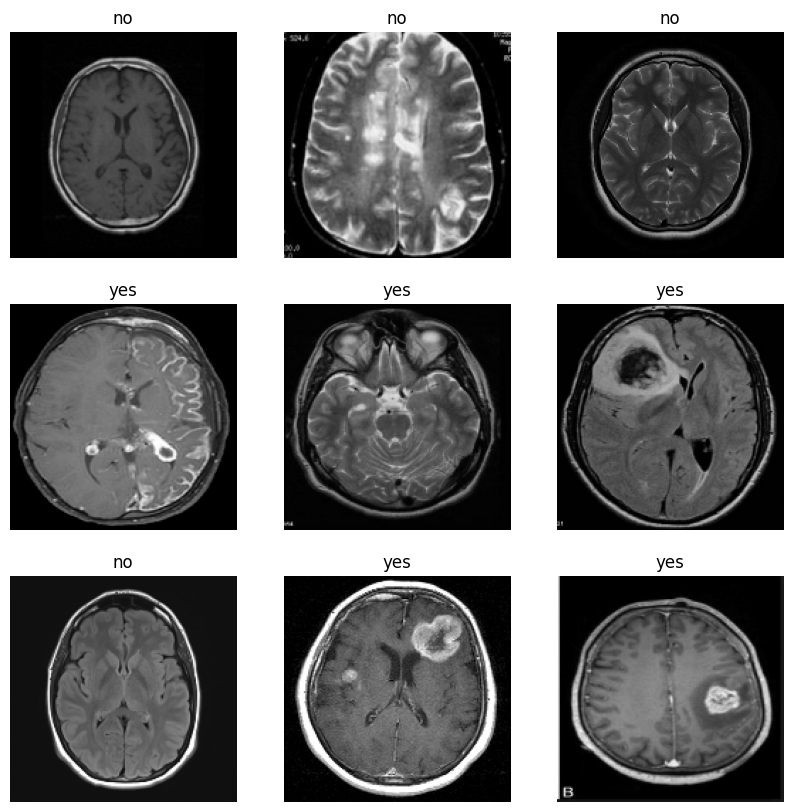

In [4]:
class_names = training_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

3. DEFINING DATA AUGMENTATION AND MODEL FUNCTIONS

In [15]:
def data_augmenter():
    """ augment your data for making your data less prone to overfitting.
    :returns: data augmentation model
    """

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip("vertical"))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.34))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomCrop(160,160))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomContrast(0.7, 1.2))
    
    return data_augmentation

In [16]:
def tumor_identifier(image_shape=(160,160), data_augmentation=data_augmenter()):
    """ create a model for your tumor identification project. you can also use other applications of keras.
    :param image_shape: shape of the input images
    :type image_shape: tuple
    :param data
    """

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 
    
    x = data_augmentation(inputs) 
    x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
    
    x = base_model(x, training=False) 
    
    x = tf.keras.layers.GlobalMaxPooling2D()(x) 
    x = tf.keras.layers.Dropout(0.34)(x)
        
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    

    return model

4. COMPILING AND SETTING METRICS

In [22]:
brain_model = tumor_identifier((160,160), data_augmenter())

brain_model.summary()

brain_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,530,993
Trainable params: 1,025
Non-trainable params: 1,529,968
_____________________________________________

5. TRAINING AND GETTING RESULTS

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,)
history = brain_model.fit(
        training_set,
        validation_data=test_set,
        epochs=300, 
        shuffle=True, 
        verbose=True,
        callbacks=[early_stopping])


Epoch 1/300
8/8 [==============================] - 4s 176ms/step - loss: 0.7956 - accuracy: 0.5044 - val_loss: 0.7103 - val_accuracy: 0.4750
Epoch 2/300
8/8 [==============================] - 0s 30ms/step - loss: 0.6924 - accuracy: 0.5921 - val_loss: 0.6491 - val_accuracy: 0.6000
Epoch 3/300
8/8 [==============================] - 0s 30ms/step - loss: 0.5880 - accuracy: 0.6579 - val_loss: 0.5930 - val_accuracy: 0.6750
Epoch 4/300
8/8 [==============================] - 0s 31ms/step - loss: 0.5849 - accuracy: 0.7061 - val_loss: 0.5686 - val_accuracy: 0.7000
Epoch 5/300
8/8 [==============================] - 0s 30ms/step - loss: 0.5132 - accuracy: 0.7588 - val_loss: 0.5429 - val_accuracy: 0.7000
Epoch 6/300
8/8 [==============================] - 0s 30ms/step - loss: 0.5014 - accuracy: 0.7325 - val_loss: 0.5174 - val_accuracy: 0.7750
Epoch 7/300
8/8 [==============================] - 0s 31ms/step - loss: 0.4485 - accuracy: 0.8246 - val_loss: 0.5125 - val_accuracy: 0.7500
Epoch 8/300
8/8 [==

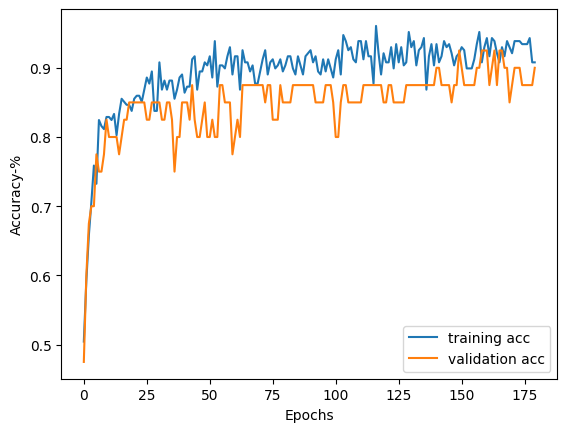

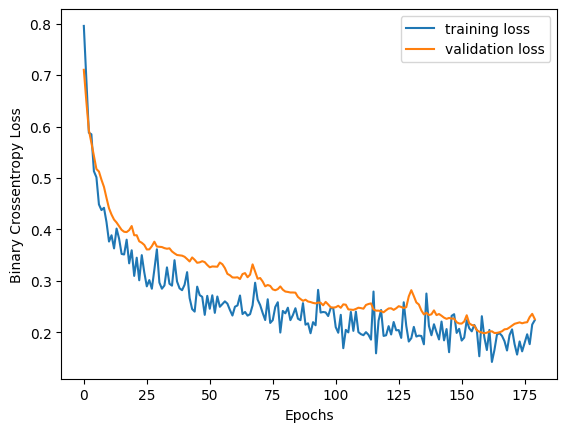

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-%')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

Brain model is performing succesfully. Now we can evaluate our model.

6. EVALUATION OF MODEL

In [25]:
train_result = brain_model.evaluate(training_set)
val_result = brain_model.evaluate(test_set)

2/2 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9250


7. FINAL RESULTS: 94.74% ACCURACY ON TRAINING SET
                  92.50% ACCURACY ON TEST SET